***Import the required libraries***

In [80]:
import numpy as np
import scipy as sp
import pandas as pd
from scipy.stats import spearmanr
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

***Data Reading***

In [2]:
nf_sub_cost = pd.read_csv("./Data_Sets/NetFlix_Subscriptions_Costs.csv")

***Data Description***

In [3]:
# Shape of data
nf_sub_cost.shape  # Only 65 observations of 7 features

(65, 7)

In [4]:
# Feature information
nf_sub_cost.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Country                        65 non-null     object 
 1   Total Library Size             65 non-null     int64  
 2   No. of TV Shows                65 non-null     int64  
 3   No. of Movies                  65 non-null     int64  
 4   Cost Per Month - Basic ($)     65 non-null     float64
 5   Cost Per Month - Standard ($)  65 non-null     float64
 6   Cost Per Month - Premium ($)   65 non-null     float64
dtypes: float64(3), int64(3), object(1)
memory usage: 3.7+ KB


In [5]:
# Get only the numeric columns
numeric_columns = nf_sub_cost.dtypes[nf_sub_cost.dtypes != "object"].index

In [6]:
nf_sub_cost[numeric_columns].describe()

,Total Library Size,No. of TV Shows,No. of Movies,Cost Per Month - Basic ($),Cost Per Month - Standard ($),Cost Per Month - Premium ($)
count,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000
mean,5314.415385,3518.953846,1795.461538,8.368462,11.990000,15.612923
std,980.322633,723.010556,327.279748,1.937819,2.863979,4.040672
min,2274.000000,1675.000000,373.000000,1.970000,3.000000,4.020000
25%,4948.000000,3154.000000,1628.000000,7.990000,10.710000,13.540000
50%,5195.000000,3512.000000,1841.000000,8.990000,11.490000,14.450000
75%,5952.000000,3832.000000,1980.000000,9.030000,13.540000,18.060000
max,7325.000000,5234.000000,2387.000000,12.880000,20.460000,26.960000


***Data Cleaning***

**Although it is clear that the data set does not have any missing data, still we insist on finding it in an alternate way**

In [7]:
nf_sub_cost.isna().sum()  # No missing value

Country                          0
Total Library Size               0
No. of TV Shows                  0
No. of Movies                    0
Cost Per Month - Basic ($)       0
Cost Per Month - Standard ($)    0
Cost Per Month - Premium ($)     0
dtype: int64

**Also check for infinity values**

In [8]:
nf_sub_cost[
    [
        "Total Library Size", "No. of TV Shows", "No. of Movies",
        "Cost Per Month - Basic ($)", "Cost Per Month - Standard ($)",
        "Cost Per Month - Premium ($)"
    ]
].isin([np.inf, -np.inf]).sum()  # No infinite value

Total Library Size               0
No. of TV Shows                  0
No. of Movies                    0
Cost Per Month - Basic ($)       0
Cost Per Month - Standard ($)    0
Cost Per Month - Premium ($)     0
dtype: int64

**Drop duplicates (if any)**

In [9]:
nf_sub_cost.shape

(65, 7)

In [10]:
nf_sub_cost_1 = nf_sub_cost.copy()  # Take a copy before attempting to drop duplicate observations (if any)
nf_sub_cost.drop_duplicates(inplace=True)
nf_sub_cost.shape  # Shape remains same; no duplicate observation

(65, 7)

**Outlier check**

In [11]:
skew_limit = 0.75

In [12]:
skewed_columns = []
for numeric_column in numeric_columns:
    if skew_limit < abs(nf_sub_cost[numeric_column].skew()):
        skewed_columns.append(numeric_column)
skewed_columns  # Columns with skew above the permissible limit of 0.75

['No. of Movies', 'Cost Per Month - Basic ($)']

In [13]:
nf_sub_cost[skewed_columns].skew()  # Skew of the identified columns

No. of Movies                -2.014921
Cost Per Month - Basic ($)   -0.968166
dtype: float64

<AxesSubplot:xlabel='No. of Movies', ylabel='Count'>

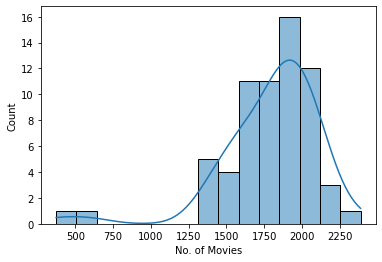

In [14]:
sns.histplot(nf_sub_cost["No. of Movies"], kde=True, bins=15)

<AxesSubplot:xlabel='No. of Movies', ylabel='Count'>

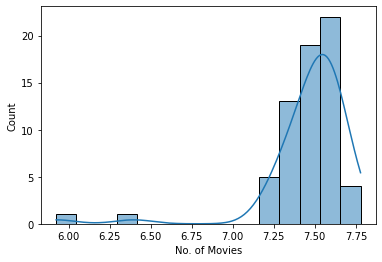

In [15]:
# CLearly, log transformation made the data more right skewed 
sns.histplot(nf_sub_cost["No. of Movies"].apply(np.log1p), kde=True, bins=15)

<AxesSubplot:xlabel='Cost Per Month - Basic ($)', ylabel='Count'>

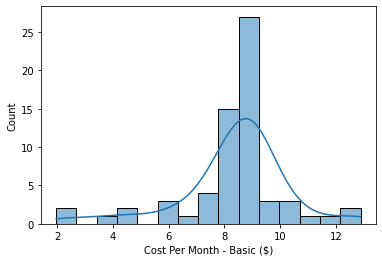

In [16]:
sns.histplot(nf_sub_cost["Cost Per Month - Basic ($)"], kde=True, bins=15)

<AxesSubplot:xlabel='Cost Per Month - Basic ($)', ylabel='Count'>

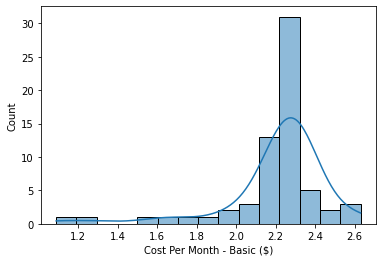

In [17]:
# Clearly, log transformation made the data more right skewed
sns.histplot(nf_sub_cost["Cost Per Month - Basic ($)"].apply(np.log1p), kde=True, bins=15)

***Feature Engineering***

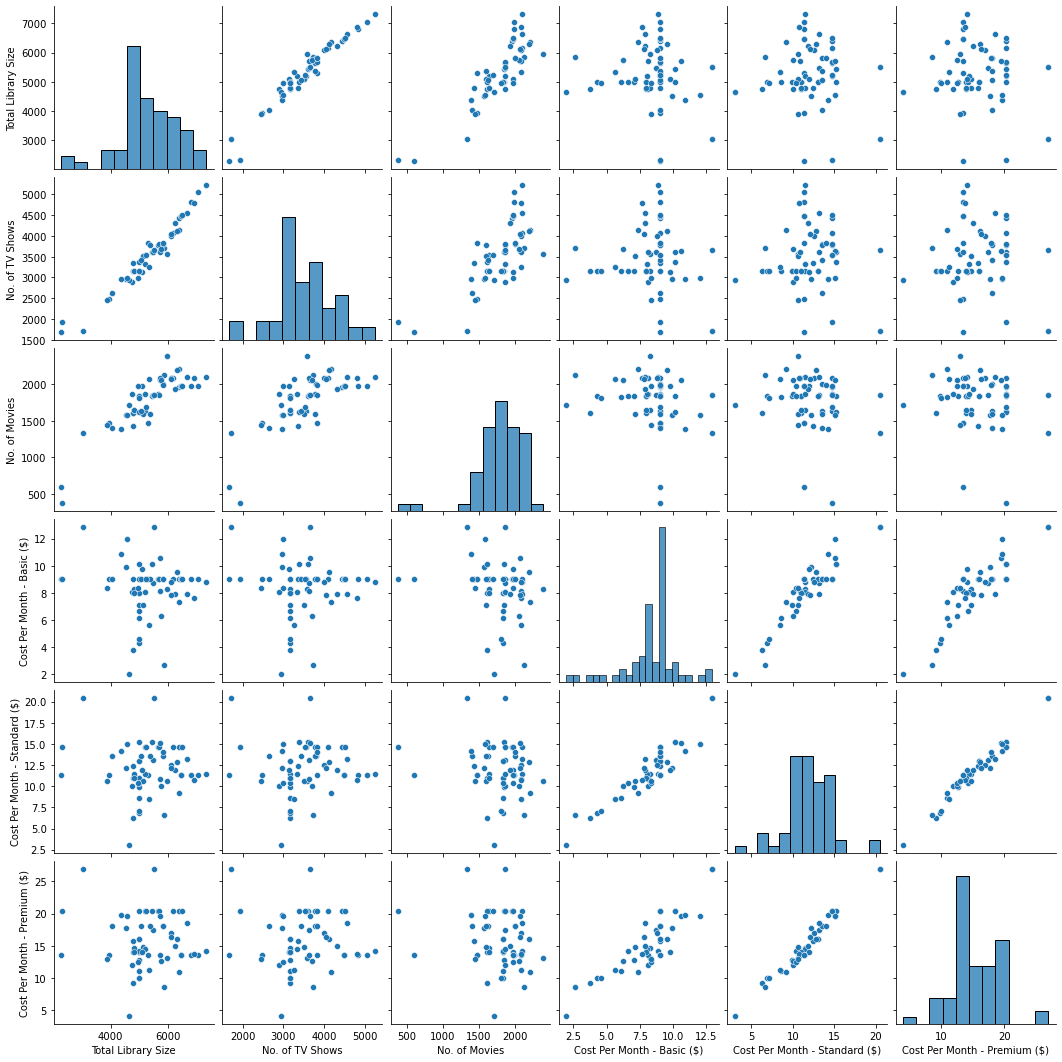

In [18]:
sns.pairplot(nf_sub_cost)

1. There is multicollinearity between/among:
    a. Total Library Size vs. No. of TV Shows
    b. Cost Per Month - Basic vs. Cost Per Month - Standard and Cost Per Month - Premium
    c. Cost Per Month - Standard vs. Cost Per Month - Basic and Cost Per Month - Premium
    d. Cost Per Month - Premium vs. Cost Per Month - Basic and Cost Per Month - Standard

**Feature Interaction**

In [20]:
nf_sub_cost_2 = nf_sub_cost.copy() # Take a copy before adding columns to capture probable feature interaction
nf_sub_cost.insert(
    5,
    "Basic Subscription Worth By Content Volume",
    nf_sub_cost["Cost Per Month - Basic ($)"] / nf_sub_cost["Total Library Size"]
)

In [22]:
nf_sub_cost.insert(
    7,
    "Standard Subscription Worth By Content Volume",
    nf_sub_cost["Cost Per Month - Standard ($)"] / nf_sub_cost["Total Library Size"]
)

In [24]:
nf_sub_cost["Premium Subscription Worth By Content Volume"] = nf_sub_cost["Cost Per Month - Premium ($)"] / nf_sub_cost["Total Library Size"]
nf_sub_cost

,Country,Total Library Size,No. of TV Shows,No. of Movies,Cost Per Month - Basic ($),Basic Subscription Worth By Content Volume,Cost Per Month - Standard ($),Standard Subscription Worth By Content Volume,Cost Per Month - Premium ($),Premium Subscription Worth By Content Volume
0,Argentina,4760,3154,1606,3.74,0.000786,6.30,0.001324,9.26,0.001945
1,Austria,5640,3779,1861,9.03,0.001601,14.67,0.002601,20.32,0.003603
2,Bolivia,4991,3155,1836,7.99,0.001601,10.99,0.002202,13.99,0.002803
3,Bulgaria,6797,4819,1978,9.03,0.001329,11.29,0.001661,13.54,0.001992
4,Chile,4994,3156,1838,7.07,0.001416,9.91,0.001984,12.74,0.002551
...,...,...,...,...,...,...,...,...,...,...
60,Ireland,6486,4515,1971,9.03,0.001392,14.67,0.002262,20.32,0.003133
61,Switzerland,5506,3654,1852,12.88,0.002339,20.46,0.003716,26.96,0.004896
62,Australia,6114,4050,2064,7.84,0.001282,12.12,0.001982,16.39,0.002681
63,Denmark,4558,2978,1580,12.00,0.002633,15.04,0.003300,19.60,0.004300


In [26]:
def add_deviation_feature(data, category, feature):
    """Function to add feature deviation in category
    """
    grouped_data = data.groupby(category)[feature]
    category_mean = grouped_data.transform(lambda x: x.mean())
    category_std = grouped_data.transform(lambda x: x.std())
    data[feature + " Deviation In " + category] = (data[feature] - category_mean) / category_std

In [36]:
nf_sub_cost_3 = nf_sub_cost.copy()  # Take a copy before binning of the Total Library Size

In [37]:
nf_sub_cost["Total Library Size Categorized"] = pd.cut(nf_sub_cost["Total Library Size"], bins=10) # Create feature with total library size bins

In [38]:
add_deviation_feature(nf_sub_cost, "Total Library Size Categorized", "Cost Per Month - Basic ($)")

In [39]:
nf_sub_cost

,Country,Total Library Size,No. of TV Shows,No. of Movies,Cost Per Month - Basic ($),Basic Subscription Worth By Content Volume,Cost Per Month - Standard ($),Standard Subscription Worth By Content Volume,Cost Per Month - Premium ($),Premium Subscription Worth By Content Volume,Total Library Size Categorized,Cost Per Month - Basic ($) Deviation In Total Library Size Categorized
0,Argentina,4760,3154,1606,3.74,0.000786,6.30,0.001324,9.26,0.001945,"(4294.4, 4799.5]",-1.393505
1,Austria,5640,3779,1861,9.03,0.001601,14.67,0.002601,20.32,0.003603,"(5304.6, 5809.7]",0.039413
2,Bolivia,4991,3155,1836,7.99,0.001601,10.99,0.002202,13.99,0.002803,"(4799.5, 5304.6]",0.051985
3,Bulgaria,6797,4819,1978,9.03,0.001329,11.29,0.001661,13.54,0.001992,"(6314.8, 6819.9]",0.526212
4,Chile,4994,3156,1838,7.07,0.001416,9.91,0.001984,12.74,0.002551,"(4799.5, 5304.6]",-0.523143
...,...,...,...,...,...,...,...,...,...,...,...,...
60,Ireland,6486,4515,1971,9.03,0.001392,14.67,0.002262,20.32,0.003133,"(6314.8, 6819.9]",0.526212
61,Switzerland,5506,3654,1852,12.88,0.002339,20.46,0.003716,26.96,0.004896,"(5304.6, 5809.7]",2.003095
62,Australia,6114,4050,2064,7.84,0.001282,12.12,0.001982,16.39,0.002681,"(5809.7, 6314.8]",-0.016525
63,Denmark,4558,2978,1580,12.00,0.002633,15.04,0.003300,19.60,0.004300,"(4294.4, 4799.5]",1.312903


***Hypothesis Testing***

**Correlation hypothesis: base package price varies with content volume**

In [101]:
nf_sub_cost_4 = nf_sub_cost_1.copy()
nf_sub_cost_4.drop("Country", axis=1, inplace=True)
sample_1 = nf_sub_cost_4.sample(n=30, random_state=10)

In [102]:
standard_scaler = StandardScaler()
sample_1[:] = standard_scaler.fit_transform(sample_1)
sample_1

,Total Library Size,No. of TV Shows,No. of Movies,Cost Per Month - Basic ($),Cost Per Month - Standard ($),Cost Per Month - Premium ($)
20,0.509276,0.320419,0.800532,0.958553,0.947337,0.869656
2,-0.134564,-0.311651,0.232950,-0.251210,-0.411420,-0.430378
53,-0.696364,-0.544048,-0.887211,1.118599,0.662868,0.907135
3,1.475928,1.813124,0.588001,0.238344,-0.311019,-0.535786
6,-0.137240,-0.315481,0.232950,0.219515,0.257918,0.038103
37,0.529786,0.366387,0.768027,-1.065564,-0.726009,-0.760656
19,0.625203,0.407248,0.955554,-2.769588,-1.877271,-1.692933
43,-0.136348,-0.312928,0.230450,0.219515,0.257918,0.038103
50,1.553510,1.791417,0.848039,-0.415964,-0.505127,-0.479568
26,-1.074464,-1.182502,-0.697184,0.238344,-0.311019,-0.535786


In [112]:
total_library_size = sample_1["Total Library Size"]
basic_package_price = sample_1["Cost Per Month - Basic ($)"]

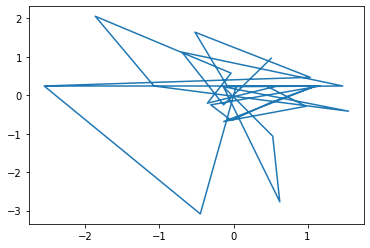

In [113]:
plt.plot(total_library_size, basic_package_price)

In [115]:
stat, p = spearmanr(total_library_size, basic_package_price)
if p > 0.05:
    print(f"p-value is {p}; that is there is weak correlation and base package price does not vary with total library size.")
else:
    print(f"p-value is {p}; that is there is strong correlation and base package price varies with total library size.")

p-value is 0.3473647271992212; that is there is weak correlation and base package price does not vary with total library size.
